#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/min.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()   

	

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
4046,27/07/2022,49.180000,49.669998,48.380001,48.799999,48.799999,1093958,1.35,2.5,125.0
4047,28/07/2022,50.990002,53.650002,49.520000,53.209999,53.209999,2970775,1.35,2.5,125.0
4048,29/07/2022,54.610001,56.049999,53.520000,53.740002,53.740002,1829089,1.35,2.5,125.0
4049,1/08/2022,54.509998,55.099998,53.820000,53.959999,53.959999,918089,1.35,2.5,125.0
4050,2/08/2022,53.509998,54.180000,52.380001,53.080002,53.080002,1109965,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
# db.min.drop()

# # Insert all the records in the CSV into MongoDb
# records=df.to_dict('records')
# records
# db.min.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.min.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.min.delete_one(
    {'Date': last_date}
)


DELETE: 29/08/2022 63.9900016784668


UPDATE MONGO DB

In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.min.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)


from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 65.12000274658203
Last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'MIN.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,64.32,60.580002,60.820000,63.990002,1377513,63.990002
2022-08-30,68.50,65.029999,65.360001,67.959999,1654280,67.959999


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
# stock_quote['Date']
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,64.32,60.580002,60.820000,63.990002,1377513,63.990002,1.85,2.5,125
1,30/08/2022,68.50,65.029999,65.360001,67.959999,1654280,67.959999,1.85,2.5,125


In [9]:
records=stock_quote.to_dict('records',)
print(records)

[{'Date': '29/08/2022', 'High': 64.31999969482422, 'Low': 60.58000183105469, 'Open': 60.81999969482422, 'Close': 63.9900016784668, 'Volume': 1377513, 'Adj Close': 63.9900016784668, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}, {'Date': '30/08/2022', 'High': 68.5, 'Low': 65.02999877929688, 'Open': 65.36000061035156, 'Close': 67.95999908447266, 'Volume': 1654280, 'Adj Close': 67.95999908447266, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}]


In [10]:
db.min.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.min.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62ff43204f53ff7c3bbcb32c'), '17/08/2022', 60.75,
        61.65999984741211, 59.720001220703125, 60.52000045776367,
        60.52000045776367, 910760, 1.85, 2.5, 125.0],
       [ObjectId('62ff43204f53ff7c3bbcb32d'), '18/08/2022',
        59.349998474121094, 59.9900016784668, 57.59000015258789,
        59.900001525878906, 59.900001525878906, 1083399, 1.85, 2.5,
        125.0],
       [ObjectId('63035c0e33dceae6fe463cfc'), '19/08/2022',
        60.97999954223633, 60.97999954223633, 59.939998626708984,
        60.900001525878906, 60.900001525878906, 911430, 1.85, 2.5, 125.0],
       [ObjectId('6304a90fdf3c4d77038f7dab'), '22/08/2022',
        59.599998474121094, 62.06999969482422, 59.279998779296875,
        61.560001373291016, 61.560001373291016, 772433, 1.85, 2.5, 125.0],
       [ObjectId('6307435fda21b20cb66ce6a8'), '23/08/2022',
        61.400001525878906, 63.15999984741211, 61.0, 61.75, 61.75,
        729870, 1.85, 2.5, 125.0],
       [ObjectId('6307435fda21b20cb66ce

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

30/08/2022 67.95999908447266


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.min.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(4071, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(3257, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.00014966, 0.00014966, 0.00014966, 0.00082311,
       0.00119725, 0.00164621, 0.00209518, 0.00239449, 0.00239449,
       0.00314277, 0.00329243, 0.00314277, 0.00254415, 0.00239449,
       0.00239449, 0.0026938 , 0.0026938 , 0.00314277, 0.00239449,
       0.00254415, 0.0026938 , 0.00239449, 0.00239449, 0.00239449,
       0.00314277, 0.00374139, 0.00374139, 0.00389105, 0.00389105,
       0.00389105, 0.00359174, 0.00389105, 0.00389105, 0.00389105,
       0.00419036, 0.00434002, 0.00419036, 0.00419036, 0.00419036,
       0.00389105, 0.00389105, 0.00336726, 0.00344208, 0.00359174,
       0.00389105, 0.00419036, 0.00389105, 0.00419036, 0.00463933,
       0.00419036, 0.00419036, 0.00478899, 0.00463933, 0.00434002,
       0.00538761, 0.0050883 , 0.00538761, 0.00763245, 0.00838072])]
[0.00823106865512973]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(3197, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3197, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3197/3197 [==============================] - 130s 40ms/step - loss: 1.8116e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
y_test.dtype

dtype('float64')

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.4103004308414693

C:\Users\antoi\AppData\Local\Temp/ipykernel_26904/583277699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


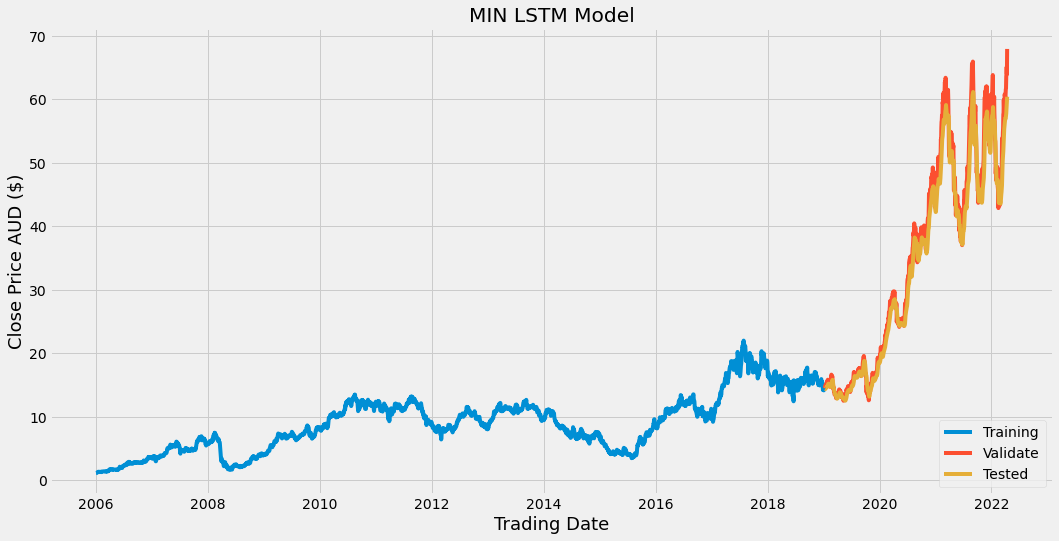

In [26]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('MIN LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
# x = np.arange(2006,2022,9)
plt.xticks([0,500,1000,1500,2000,2500,3000,3500,4000],[2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.savefig('../static/data/images/min_graph.png')
plt.show()

# Test data Predictions on the Model

In [27]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_26904/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
3257  14.500000    14.408345    0.091655
3258  14.990000    14.387910    0.602090
3259  14.900000    14.442719    0.457281
3260  14.960000    14.496498    0.463502
3261  15.020000    14.549824    0.470176
...         ...          ...         ...
4066  63.590000    57.779381    5.810619
4067  63.970001    58.486851    5.483150
4068  65.120003    59.216465    5.903538
4069  63.990002    60.052444    3.937557
4070  67.959999    60.429005    7.530994

[814 rows x 3 columns]>

In [28]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.min.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [29]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [30]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $67.95999908447266 Predicted next day share price $59.61


# Save the Model

In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/min_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list min_sixty and load df

#PREDICT USING LOADED MODEL

In [32]:
from keras.models import load_model
model_in = load_model('../static/min_model.sav')

In [33]:
# query the min collection and load into dataframe

df_mongo = pd.DataFrame(list(db.min.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[58.990002  ],
       [59.23      ],
       [57.919998  ],
       [55.880001  ],
       [52.720001  ],
       [53.400002  ],
       [52.860001  ],
       [51.279999  ],
       [48.049999  ],
       [48.639999  ],
       [48.080002  ],
       [46.529999  ],
       [46.650002  ],
       [48.509998  ],
       [48.5       ],
       [48.645     ],
       [47.919998  ],
       [46.27      ],
       [45.299999  ],
       [45.509998  ],
       [42.75      ],
       [44.        ],
       [45.869999  ],
       [46.009998  ],
       [44.310001  ],
       [43.27      ],
       [44.73      ],
       [43.369999  ],
       [43.5       ],
       [44.950001  ],
       [46.174999  ],
       [46.34      ],
       [46.5       ],
       [47.09      ],
       [47.98      ],
       [48.380001  ],
       [49.52      ],
       [53.52      ],
       [53.82      ],
       [52.38000107],
       [52.38499832],
       [54.58000183],
       [55.59999847],
       [56.84999847],
       [57.72000122],
       [58

In [34]:
# workings for scatterplot
# df_mongo_min = pd.DataFrame(list(db.min.find()))
# df_min = df_mongo_min.iloc[-4250:]
# min_dict = df_min.to_dict(orient='records')
# #print(min_dict)

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/min_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_min(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_min(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[61.83,
 61.73,
 61.44,
 61.06,
 60.67,
 60.28,
 59.91,
 59.56,
 59.25,
 58.96,
 58.7,
 58.46,
 58.25,
 58.06,
 57.88,
 57.71,
 57.55,
 57.4,
 57.26,
 57.12,
 56.98,
 56.87,
 56.74,
 56.61,
 56.48,
 56.36,
 56.24,
 56.12,
 56.01,
 55.95,
 55.91,
 55.83,
 55.76,
 55.71,
 55.68,
 55.64,
 55.63,
 55.68,
 55.66,
 55.64,
 55.63,
 55.66,
 55.67,
 55.67,
 55.68,
 55.68,
 55.68,
 55.68,
 55.68,
 55.67,
 55.67,
 55.67,
 55.66,
 55.66,
 55.66,
 55.65,
 55.65,
 55.64,
 55.64,
 55.63,
 55.63,
 55.63,
 55.63,
 55.63,
 55.63,
 55.63,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.62,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 55.61,
 5

In [36]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)


<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [37]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')

#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')
today_str=today1.strftime('%d-%m-%Y')
print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')
    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)
    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
5:16:12.617437
[[ObjectId('630dc684ae0967d012939261') 11 '14-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939262') 12 '15-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939263') 13 '16-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939264') 14 '19-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d012939265') 15 '20-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d012939266') 16 '21-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d012939267') 17 '22-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d012939268') 18 '23-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d012939269') 19 '26-09-2022' 'Monday']
 [ObjectId('630dc684ae0967d01293926a') 20 '27-09-2022' 'Tuesday']
 [ObjectId('630dc684ae0967d01293926b') 21 '28-09-2022' 'Wednesday']
 [ObjectId('630dc684ae0967d01293926c') 22 '29-09-2022' 'Thursday']
 [ObjectId('630dc684ae0967d01293926d') 23 '30-09-2022' 'Friday']
 [ObjectId('630dc684ae0967d01293926e') 24 '03-10-2022' 'Monday']
 [ObjectId('630dc6

C:\Users\antoi\AppData\Local\Temp/ipykernel_26904/2081463777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


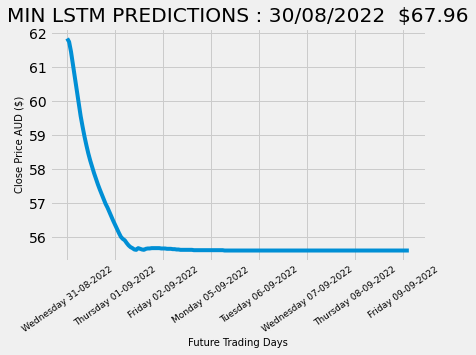

In [38]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('MIN LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/min_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 61.83},
 {'Price': 61.73},
 {'Price': 61.44},
 {'Price': 61.06},
 {'Price': 60.67},
 {'Price': 60.28},
 {'Price': 59.91},
 {'Price': 59.56},
 {'Price': 59.25},
 {'Price': 58.96},
 {'Price': 58.7},
 {'Price': 58.46},
 {'Price': 58.25},
 {'Price': 58.06},
 {'Price': 57.88},
 {'Price': 57.71},
 {'Price': 57.55},
 {'Price': 57.4},
 {'Price': 57.26},
 {'Price': 57.12},
 {'Price': 56.98},
 {'Price': 56.87},
 {'Price': 56.74},
 {'Price': 56.61},
 {'Price': 56.48},
 {'Price': 56.36},
 {'Price': 56.24},
 {'Price': 56.12},
 {'Price': 56.01},
 {'Price': 55.95},
 {'Price': 55.91},
 {'Price': 55.83},
 {'Price': 55.76},
 {'Price': 55.71},
 {'Price': 55.68},
 {'Price': 55.64},
 {'Price': 55.63},
 {'Price': 55.68},
 {'Price': 55.66},
 {'Price': 55.64},
 {'Price': 55.63},
 {'Price': 55.66},
 {'Price': 55.67},
 {'Price': 55.67},
 {'Price': 55.68},
 {'Price': 55.68},
 {'Price': 55.68},
 {'Price': 55.68},
 {'Price': 55.68},
 {'Price': 55.67},
 {'Price': 55.67},
 {'Price': 55.67},
 {'Price': 55.

In [40]:
# len_df_mongo = len(df.index) # length of the original dataframe
len_df_mongo=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

3257 4071 4231


,Close
4220,55.61
4221,55.61
4222,55.61
4223,55.61
4224,55.61
4225,55.61
4226,55.61
4227,55.61
4228,55.61
4229,55.61


C:\Users\antoi\AppData\Local\Temp/ipykernel_26904/1227892185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


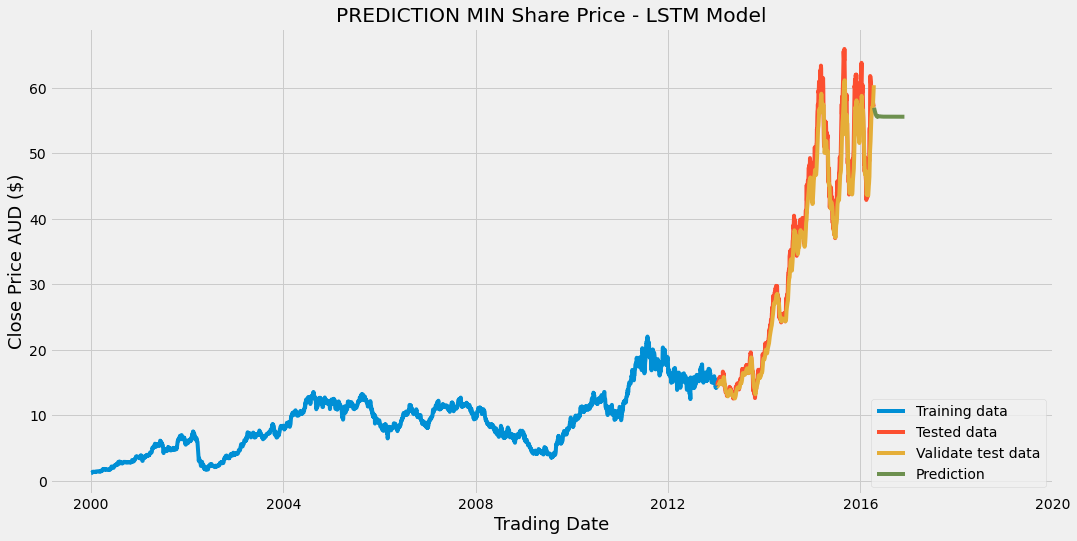

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION MIN Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/min_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'MIN'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62f83473d6fc67e45e0eff78'), 'model': 'RFR', 'name': 'MIN', 'date': '12/08/2022', 'predicted': 38, 'actual': 59, 'difference': -20.3236, 'accuracy': 93.74}
{'_id': ObjectId('630c8ec2135a740543b40a14'), 'model': 'LSTM', 'name': 'MIN', 'date': '29/08/2022', 'predicted': 64.41, 'actual': 63.99, 'difference': 0.42, 'rmse': 0.75166}


In [43]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f83473d6fc67e45e0eff78'), 'model': 'RFR', 'name': 'MIN', 'date': '12/08/2022', 'predicted': 38, 'actual': 59, 'difference': -20.3236, 'accuracy': 93.74}


In [44]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022,predicted $59.61, actual $67.96, difference -8.349999999999994, rmse 1.4103


In [45]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f83473d6fc67e45e0eff78'), 'model': 'RFR', 'name': 'MIN', 'date': '12/08/2022', 'predicted': 38, 'actual': 59, 'difference': -20.3236, 'accuracy': 93.74}
{'_id': ObjectId('630dcdc7b39ec0aa044e0443'), 'model': 'LSTM', 'name': 'MIN', 'date': '30/08/2022', 'predicted': 59.61, 'actual': 67.96, 'difference': -8.35, 'rmse': 1.4103}


In [46]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'